In [50]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(10)


# K = number of arms
# mu = mean
# sd = std. deviation

class EnvSetup(object):
    def __init__(self, K=10, mu=0, sd=1):
        self.K = K;
        self.actions = np.arange(K)
      # we can even have different sd for different arms 
        self.sd = sd
        
      # q* for each arm
        self.q_star = np.random.normal(loc=mu, scale=sd, size=K)
      
      #optimal action = max of q*
        self.optimal_action = np.argmax(self.q_star)
        

            
    def reward(self, action):
        return np.random.normal(self.q_star[action], scale=self.sd)


setup = EnvSetup()





In [51]:
class sofAgent(object):
    def __init__(self, env, beta=1):
        self.env = env
        self.beta = beta
        
        self.rewards_log = []
        self.action_log = []
        #estimate for q
        self.q = np.repeat(0., env.actions.shape[0])
        
        self.no_of_pulls = np.repeat(0, env.actions.shape[0])
        self.q_till_now = np.repeat(0., env.actions.shape[0])

    def update_q(self):
        self.q = self.q_till_now / self.no_of_pulls
        
    
    def init_q(self, rounds=1):
        """Initializing q by pulling out each arm """
        for _ in range(rounds):
            for action in self.env.actions:
                rew = self.env.reward(action)
                self.q_till_now[action] += rew
                self.no_of_pulls[action] += 1
        self.update_q()
        
        
        
    def pi(self):
        self.prob_list =  np.exp(self.q) / np.cumsum(np.exp(self.q))
        self.wt = self.prob_list * self.q
        A_t = np.where(np.random.choice(self.wt))
        return A_t
        
        
    def step(self, action=None):
        if action is None:
            action = self.pi()
        rew = self.env.reward(action)
        self.q_till_now[action] += rew
        self.no_of_pulls[action] += 1
        self.q[action] = self.q_till_now[action] / self.no_of_pulls[action]
        
        self.rewards_log.append(rew)
        self.action_log.append(action)
        
    def compute_value_history(self):
        """calculate value_history based on reward_history, undiscounted"""
        return np.cumsum(self.rewards_log) / (np.arange(len(self.rewards_log)) + 1)
    
    
    def compute_frac_optim_action_history(self):
        optimal_action = np.argmax(self.env.q_star)
        act_hist = np.array(self.action_log)
        frac_hist = []
        for i in np.arange(act_hist.shape[0]) + 1:
            sub_hist = act_hist[:i]
            mask = sub_hist == optimal_action
            frac = sub_hist[mask].shape[0] / i
            frac_hist.append(frac)
        return frac_hist

   

In [52]:
num_repeats = 2000
num_steps = 1000
beta = [0.1, 0.01,0.001,0.1]
ave_rewards_dd = {}


for eps in beta:
    val_hist_list = [] # records value history of all steps
    frac_hist_list = []
    for _ in range(num_repeats):
        ag = sofAgent(env=setup)
        ag.init_q()
        for i in range(num_steps):
            ag.step()
        val_hist_list.append(ag.compute_value_history())
       
     
        
    val_hist_arr = np.array(val_hist_list)
    ave_rewards_dd[eps] = val_hist_arr.mean(axis=0)
    
    

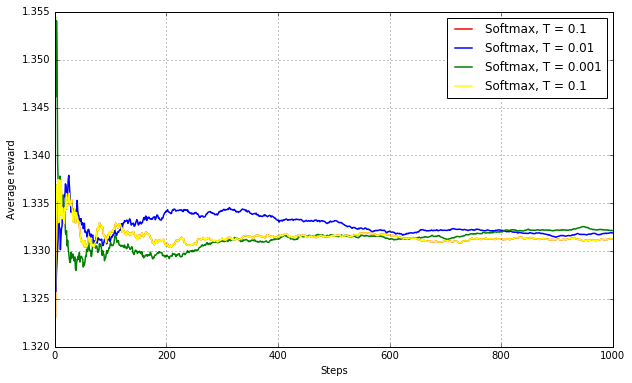

In [54]:
plt.figure(figsize=(10, 6))
colors = ['red','blue', 'green', 'yellow']
for k, b in enumerate(beta):
    col = colors[k]
    steps = np.arange(1000)
    plt.plot(steps, ave_rewards_dd[b], color=col, lw=1.5, label='Softmax, T = {0}'.format(b))
    
plt.legend(loc='best')
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Average reward')